In [1]:
import os
import wfdb
import numpy as np
import math
import matplotlib.pyplot as plt
path = r"C:\Users\paul.ilioaica\Downloads\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0"

## Loading pacients data

In [2]:
pacients_dir = [x.strip("\n") for x in open(os.path.join(path,"RECORDS"), "r").readlines()] + [x.strip("\n") for x in open(os.path.join(path,"CONTROLS"), "r").readlines()]

accepted_diseases = {'Myocardial infarction':0,
 'Healthy control':1,
 'Cardiomyopathy':2,
 'Dysrhythmia':3,
 'Bundle branch block':4}

pacients = []
for pacient in pacients_dir:
    current_path = os.path.join(path, pacient)
    record = wfdb.rdrecord(current_path)
    try:
        if record.__dict__["comments"][4].split(":")[1].strip() != "n/a":
            pacient = {"sex" : record.__dict__["comments"][1].split(":")[1].strip(),
                       "age" : int(record.__dict__["comments"][0].split(":")[1]),
                       "diagnostic" : record.__dict__["comments"][4].split(":")[1].strip(),
                        "signals" : record.__dict__["p_signal"]
                        }
            pacients.append(pacient)
    except:
        pass
unique_problems = list(set([pacient["diagnostic"] for pacient in pacients]))


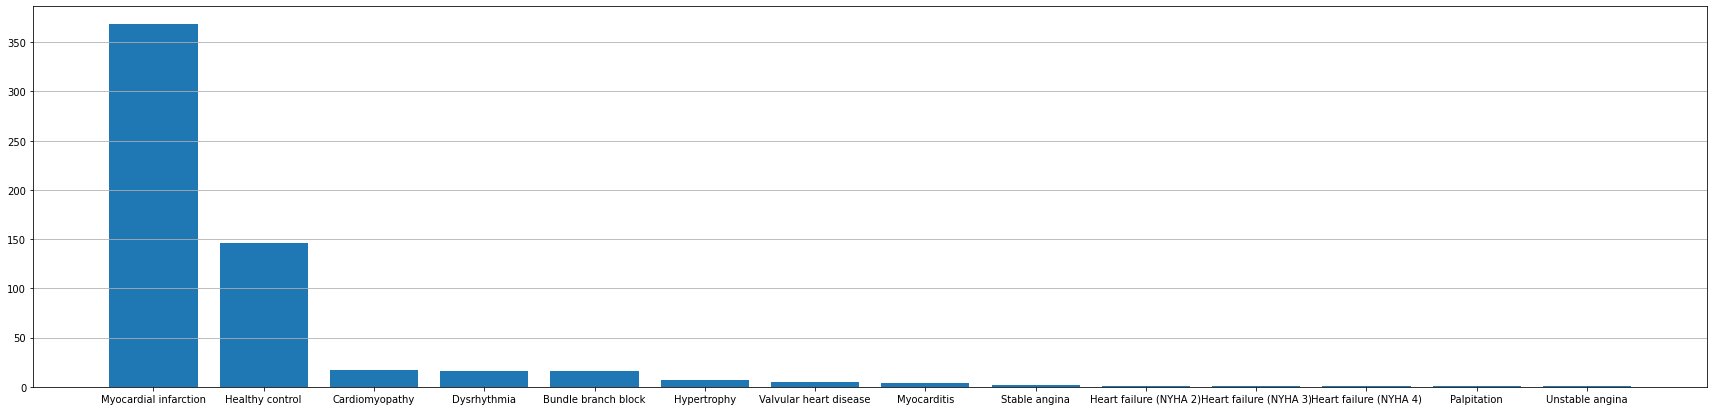

In [146]:
from collections import Counter
disease_freq = Counter([pacient["diagnostic"] for pacient in pacients]).most_common()
fig1, ax1 = plt.subplots(figsize=(30,7))
ax1.bar(height=[entry[1] for entry in disease_freq], x=[i for i in range(len(disease_freq))])
ax1.set_xticks([i for i in range(len(disease_freq))])
ax1.set_xticklabels([entry[0] for entry in disease_freq])
ax1.yaxis.grid(True)

## Generating i-wave histogram for each disease

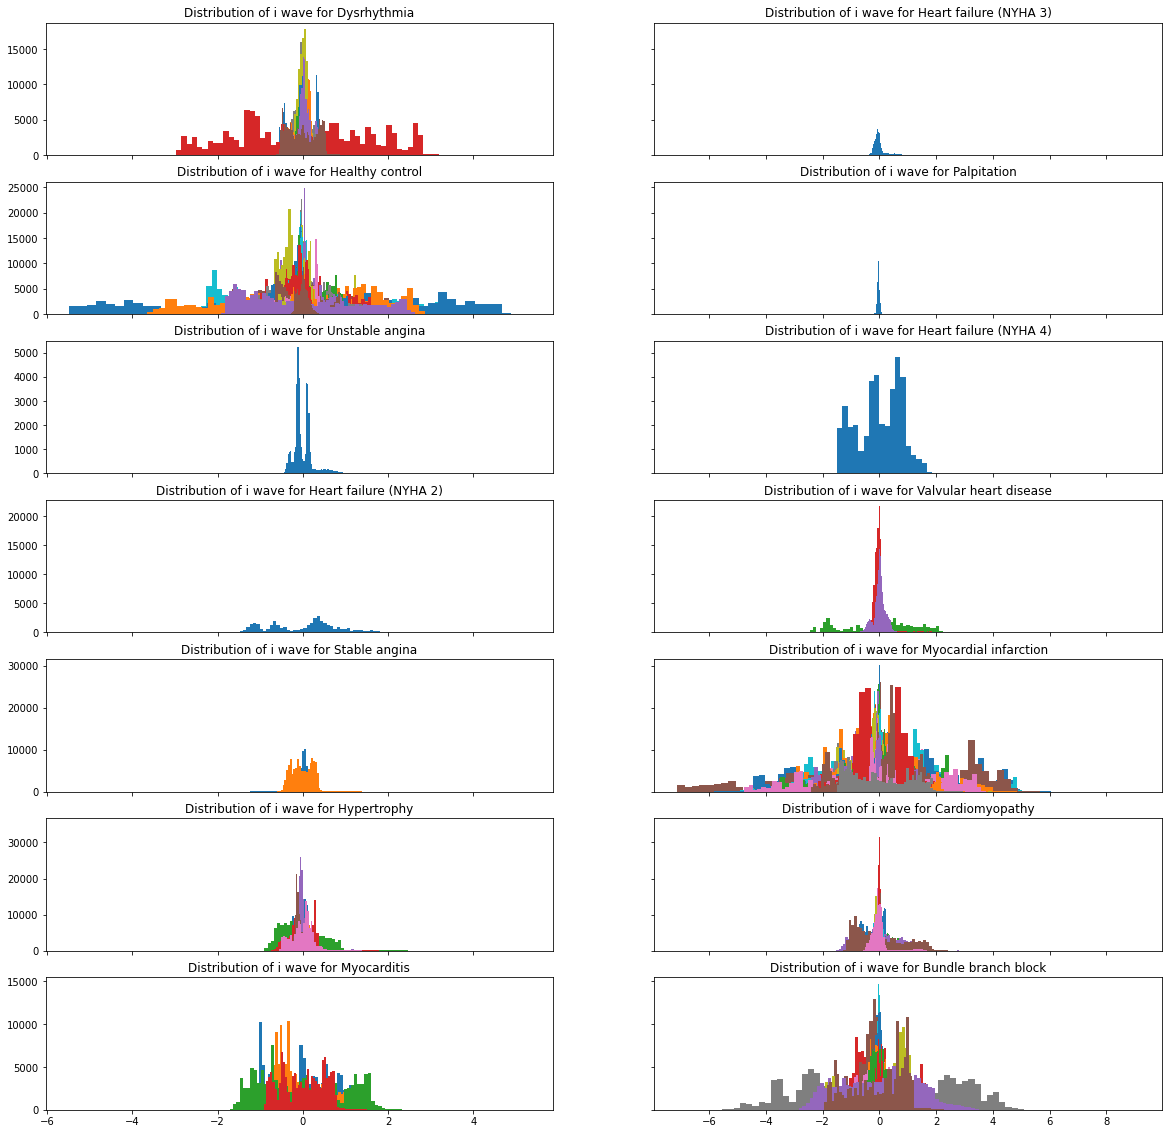

In [3]:

fig, ax = plt.subplots(7,2,sharex='col', sharey='row', figsize=(20,20))
i = 0
for figx in ax:
    for figy in figx:
        [figy.hist(pacient['signals'][:,0], bins=50) for pacient in pacients if pacient["diagnostic"] == unique_problems[i]]
        figy.set_title(f"Distribution of i wave for {unique_problems[i]}")
        i += 1

### Creating a dataset with the pacient records and i-wave features

In [33]:
from scipy.stats import kurtosis, skew

dataset = []
labels = []
sex_dict = {"male":0,
           "female":1}
disease_dict = {problem:i for i, problem in enumerate(unique_problems)}
disease_code_dict = {value:key for key, value in disease_dict.items()}

for pacient in pacients:
    if pacient['diagnostic'] in accepted_diseases:
        std = pacient["signals"][:,0].std()
        krt = kurtosis(pacient["signals"][:,0])
        skw = skew(pacient["signals"][:,0])
        rms = math.sqrt(sum(pacient["signals"][:,0]**2)/len(pacient["signals"][:,0]))
        energy = np.sum(np.abs(pacient["signals"][:,0]**2)/ len(pacient["signals"][:,0]))
        pacient_entry = [pacient["age"], sex_dict[pacient['sex']], std, krt, skw, rms, energy]
        dataset.append(pacient_entry)
        labels.append(accepted_diseases[pacient['diagnostic']])
dataset = np.array(dataset)
labels = np.array(labels)

## Kolmogorov-Smirnov test

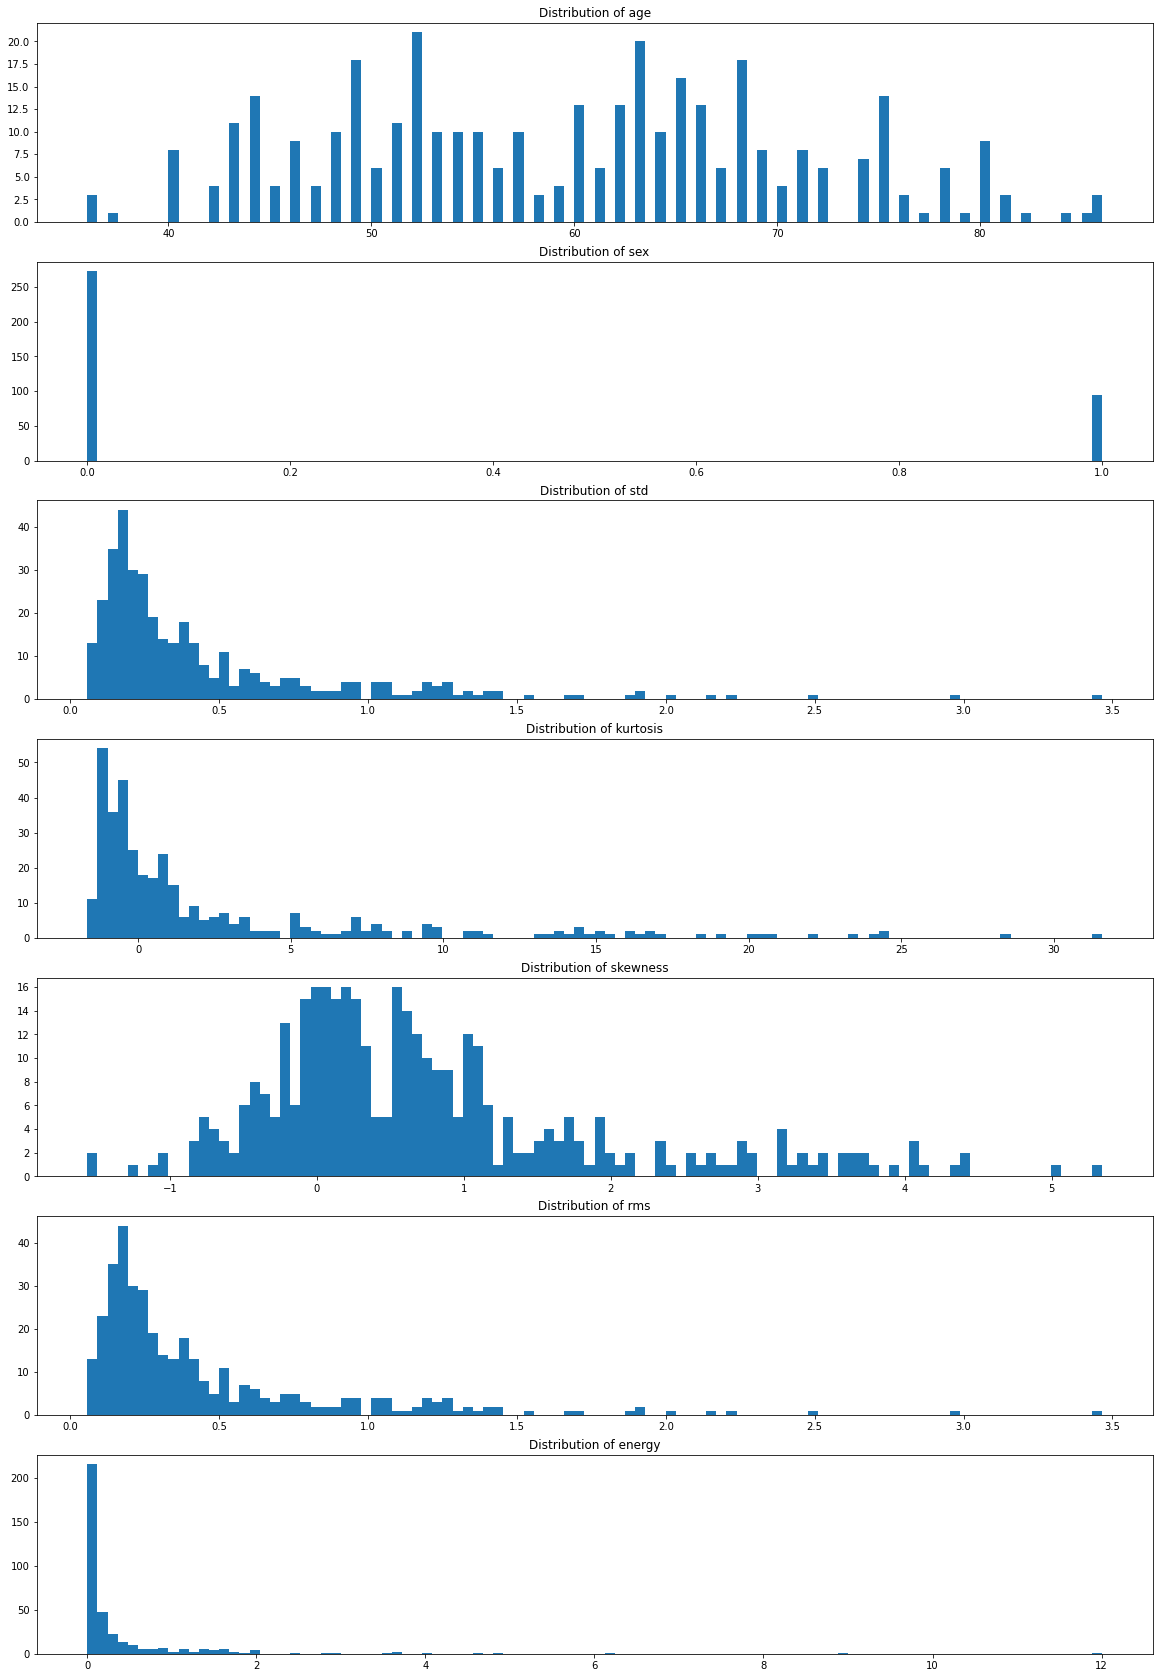

In [88]:
features = ["age","sex","std", "kurtosis", "skewness", "rms", "energy"]
fig, ax = plt.subplots(7, figsize=(20,30))
i = 0
for figx in ax:
        figx.hist(dataset[indxs][:,i], bins=100)
        figx.set_title(f"Distribution of {features[i]}")
        i += 1

In [142]:
from scipy.stats import kstest
matrx = np.ones((5,5), dtype=np.float)


for i in range(5): #boala
    indxs = np.where(labels==i)
    for j in range(2,7):
        distribution = dataset[indxs][:,j]
        result = kstest(distribution, 'norm')
        print(f" KS test for disease {disease_code_dict[i]} on feature {features[j]} gives us statistic of {result.statistic}, p-value of {result.pvalue} \n")
        matrx[i][j-2] = result.statistic

 KS test for disease Dysrhythmia on feature std gives us statistic of 0.5228652496604322, p-value of 3.458677410079329e-94 

 KS test for disease Dysrhythmia on feature kurtosis gives us statistic of 0.27710472181367696, p-value of 1.7913281052491258e-25 

 KS test for disease Dysrhythmia on feature skewness gives us statistic of 0.2724076701038137, p-value of 1.2840757822736035e-24 

 KS test for disease Dysrhythmia on feature rms gives us statistic of 0.5228652813515047, p-value of 3.458579743994219e-94 

 KS test for disease Dysrhythmia on feature energy gives us statistic of 0.5013119528206124, p-value of 4.4672140517499476e-86 

 KS test for disease Bundle branch block on feature std gives us statistic of 0.5318456360111514, p-value of 4.418135396550986e-39 

 KS test for disease Bundle branch block on feature kurtosis gives us statistic of 0.28006408573843644, p-value of 1.2765421550353653e-10 

 KS test for disease Bundle branch block on feature skewness gives us statistic of 0.

### Disease frequency

In [8]:
from collections import Counter
[disease_code_dict[x] for x,y in Counter(labels).most_common()]

['Dysrhythmia',
 'Heart failure (NYHA 3)',
 'Healthy control',
 'Palpitation',
 'Unstable angina']

### Computing covariance matrix

In [5]:
cov_matrix = np.copy(dataset)
cov_matrix -= cov_matrix.mean(axis=0)
N = cov_matrix.shape[0] 
cov_matrix = np.dot(cov_matrix.T, cov_matrix.conj()) / float(N - 1)

<AxesSubplot:>

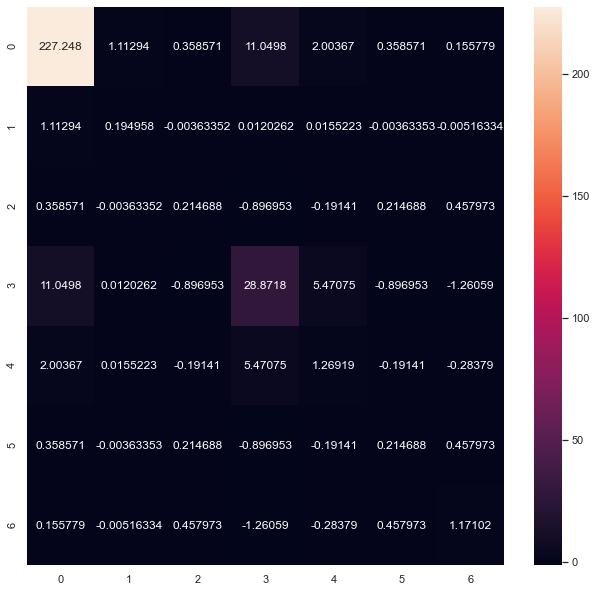

In [6]:
import seaborn as sn
sn.set(rc={'figure.figsize':(10.7,10.27)})
sn.heatmap(cov_matrix, annot=True, fmt='g')

### PCA on covariance matrix

In [7]:
eig_val, eig_vec = np.linalg.eig(cov_matrix)

In [8]:
retain_value = sum(eig_val[:4])/(sum(eig_val))
print(f"After selecting top 4 eigen values, we are keeping {100* retain_value}% of the information")

After selecting top 4 eigen values, we are keeping 99.82404189076047% of the information


In [9]:
eig_vec_filtered = eig_vec[:, :4]

In [10]:
new_dataset = eig_vec_filtered.T.dot(dataset.T)

In [11]:
print(f"Reducing the dataset size to 4 dimesions: {new_dataset.shape}")

Reducing the dataset size to 4 dimesions: (4, 563)


### K-Means Clusterization

#### Loading test data

In [12]:
ds = np.copy(new_dataset)
ds.shape

(4, 563)

In [13]:
from random import randrange
test_dataset_size = int(ds.shape[1]/10)
test_dataset = []
indexes = []
for i in range(test_dataset_size):
    index = randrange(ds.shape[1])
    test_dataset.append(ds[:, index])
    ds = np.delete(ds, (index), axis=1)
    indexes.append(index)
test_dataset = np.array(test_dataset)

In [14]:
ds.shape

(4, 507)

In [15]:
test_labels = []
for index in indexes:
    test_labels.append(labels[index])
    labels = np.delete(labels, (index), axis=0)

## Implementing K NN

In [56]:
import copy
import collections

def find_closest_k(sample, dataset, k=3):
    distances = []
    for data in dataset:
        distances.append(np.linalg.norm(sample - data))
    sort = np.argsort(np.array(distances))[:k]
    pred_labl = [labels[x] for x in sort]
    return Counter(pred_labl).most_common(k)[0][0]
    
def knn(test_data, dataset, k=5):
    predicted_labels = []
    for data in test_data:
        predicted_labels.append(find_closest_k(data, dataset ))
    return predicted_labels

In [57]:
predicted_labels = knn(test_dataset, ds.T)

In [59]:
accuracy = sum([1 if x == y else 0 for x, y in zip(test_labels, predicted_labels)]) / len(predicted_labels)

In [60]:
print(f"Accuracy using K-NN k = 3 is {accuracy}")

Accuracy using K-NN k = 3 is 0.6607142857142857


In [42]:
print(f"Accuracy using K-NN k = 5 is {accuracy}")

Accuracy using K-NN k = 5 is 0.7321428571428571


In [51]:
print(f"Accuracy using K-NN k = 7 is {accuracy}")

Accuracy using K-NN k = 7 is 0.7321428571428571
